<center> <h1>PREDICCIÓN DEL SUEÑO</h1> </center>
<center> <h3>CREACIÓN DEL DATAFRAME</h3> </center>
<center> <h4>Noemi González, Roberto Holgado y Carmen Plaza</h4> </center>

### Índice de contenidos de este Notebook

En este Notebook se realiza el preprocesado de las 3 características: frecuencia cardíaca, aceleración y pasos. Se extraen características a partir de ellas y se almacenan en un dataframe 'features' que contiene las características de los 31 sujetos. Para ello se siguen los siguientes pasos:
  
    1. Creación ventana deslizante
    2. Extracción de características y obtención dataframe 
    3. Visualización datos dataframe

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from random import sample
import statistics as stats
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

Se cargan los datos de las distintas carpetas en listas:

In [2]:
# LISTAS CON LOS NOMBRES DE TODOS LOS ARCHIVOS .txt
sujetos_sueño=[]
for file in (os.listdir("labels")):
    sujetos_sueño.append(os.path.join("labels",file))
    sujetos_sueño=sorted(sujetos_sueño)
    
sujetos_frec_card=[]
for file in os.listdir("heart_rate"):
    sujetos_frec_card.append(os.path.join("heart_rate",file))

sujetos_pasos=[]
for file in os.listdir("steps"):
    sujetos_pasos.append(os.path.join("steps",file))

sujetos_movimiento=[]
for file in os.listdir("motion"):
    sujetos_movimiento.append(os.path.join("motion",file))

### 1. Creación ventana deslizante

La ventana deslizante recorre la señal fisiológica introducida como parámetro de entrada (*signal*). La función *'get_window'*, además, toma como datos de entrada el tamaño de la ventana en segundos (*w_size*) y la longitud de la señal de las etiquetas del sueño (*n_sueño*). 

Esta función recorre el eje de tiempo de la señal deseada y va asignando índices (True o False) según se cumpla o no el parámetro establecido en el segundo bucle for. Dicha condición depende directamente del tamaño de ventana que se seleccione.
* Si el eje de tiempo está entre los valores 'a' y 'b' se asiga True
* Si esa condición no se cumplese asigna False

In [3]:
def get_window(w_size,signal,n_sueño):
    time = signal["Tiempo"]
    f_list=[]
    
    for i in range(n_sueño):
        a = w_size*(1+i)
        b = w_size*(2+i)

        idx=[]
        for t in time:
            if t>a and t<b:
                idx.append(True)
            else:
                idx.append(False)
        
        f = signal[idx]
        f_list.append(f)
    
    return f_list

En esta ocasión se selecciona una *w_size*=**30 segundos**, para tener una característica cada 30s y así hacer coincidir la cantidad de los datos adquiridos por medio del Apple Watch con los datos recogidos por la PSG.

### 2. Extracción de características y obtención del dataframe

A continuación se detallan las características extraídas con la ventana deslizante a partir de las originales:

* **feat1: min_list**: frecuencias cardíacas mínimas.
* **feat2: max_list**: frecuencias cardíacas máximas.
* **feat3: mean_list**: frecuencias cardíacas medias.

* **feat4: mean_sqrt_acc**: aceleraciones medias.

* **feat5: min_accx**: aceleraciones eje x mínimas.
* **feat6: max_accx**: aceleraciones eje x máximas.
* **feat7: mean_accx**: aceleraciones eje x medias.

* **feat8: min_accy**: aceleraciones eje y mínimas.
* **feat9: max_accy**: aceleraciones eje y máximas.
* **feat10: mean_accy**: aceleraciones eje y medias.

* **feat11: min_accz**: aceleraciones eje z mínimas.
* **feat12: max_accz**: aceleraciones eje z máximas.
* **feat13: mean_accz**: aceleraciones eje z medias.

Con todas las características se ha creado un dataframe que incluye a todos los sujetos. Además, se han añadido una columna con los **identificadores de cada sujeto** para tener los datos localizados en todo momento. 

La columna de **etiquetas binarias** es una modificación de la columna etiquetas. Se ha realizado esta modificación para crear un clasificador de salida binaria como primera aproximación.

In [4]:
df = []
for a, (i,j,k,l) in  enumerate(zip(sujetos_sueño,sujetos_frec_card,sujetos_pasos,sujetos_movimiento)):
    w_size = 30
    n_sueño = len(sueño)
    
    #SUEÑO
    sueño = pd.read_csv(i, delimiter=' ')
    sueño.columns = ["Tiempo","Etiqueta"]
    
    #SUEÑO BINARIO
    sueño_bin = sueño.replace(to_replace =[-1,5],  value =0) 
    sueño_bin = sueño_bin.replace(to_replace =[2,3,4],  value =1)    #Etiquetas binarias
    bin_labels = sueño_bin["Etiqueta"]
    
    #ID_LIST
    labels = sueño["Etiqueta"]
    id_list = [a]*len(labels)
    
    #FRECUENCIA CARDIACA
    frec_card = pd.read_csv(j)
    frec_card.columns = ["Tiempo","Frec card"]
    frec_card=frec_card[frec_card["Tiempo"]>0]

    signal = frec_card
    f_list = get_window(w_size,signal,n_sueño)

    fc_mean_list = []
    fc_min_list = []
    fc_max_list = []

    for f in f_list:
        fc_mean_list.append(round(f['Frec card'].mean(),2))
        fc_min_list.append(round(f['Frec card'].min(),2))
        fc_max_list.append(round(f['Frec card'].max(),2))
    
    feat1 = fc_min_list
    feat2 = fc_max_list
    feat3 = fc_mean_list
    
    #ACCELERACION
    mov=pd.read_csv(l, delimiter=' ')
    mov.columns=["Tiempo","Ac_x","Ac_y","Ac_z"]
    mov_t=mov[mov['Tiempo']>0]
    
    mov_t=mov_t.sample(frac=.1)
    mov_t=mov_t.sort_values('Tiempo')
    raiz_movto= np.sqrt(mov_t.Ac_x**2 + mov_t.Ac_y**2 + mov_t.Ac_z**2)
    mov_t['Raiz_movto'] = raiz_movto
    
    signal=mov_t
    acc_list= get_window(w_size,signal,n_sueño)
    
    mean_sqrt_acc=[]
    
    min_accx=[]
    max_accx=[]
    mean_accx=[]
    
    min_accy=[]
    max_accy=[]
    mean_accy=[]
    
    min_accz=[]
    max_accz=[]
    mean_accz=[]
    
    for f in acc_list:
        mean_sqrt_acc.append(round(f['Raiz_movto'].mean(),2))
        
        min_accx.append(round(f['Ac_x'].min(),2))
        max_accx.append(round(f['Ac_x'].max(),2))
        mean_accx.append(round(f['Ac_x'].mean(),2))
        
        min_accy.append(round(f['Ac_y'].min(),2))
        max_accy.append(round(f['Ac_y'].max(),2))
        mean_accy.append(round(f['Ac_y'].mean(),2))
        
        min_accz.append(round(f['Ac_z'].min(),2))
        max_accz.append(round(f['Ac_z'].max(),2))
        mean_accz.append(round(f['Ac_z'].mean(),2))
        
    feat4=mean_sqrt_acc
    
    feat5=min_accx
    feat6=max_accx
    feat7=mean_accx
    
    feat8=min_accy
    feat9=max_accy
    feat10=mean_accy
    
    feat11=min_accz
    feat12=max_accz
    feat13=mean_accz
    
    datos = {'Min_hr': feat1, "Max_hr": feat2,"Mean_hr":feat3,'Men_acc_sqrt': feat4,
             "Min_acc_x": feat5,"Max_acc_x":feat6,"Mean_acc_x": feat7,
             "Min_acc_y": feat8,"Max_acc_y":feat9,"Mean_acc_y":feat10,
             "Min_acc_z": feat11,"Max_acc_z":feat12,"Mean_acc_z":feat13,
             "Etiquetas":labels,"Etiquetas binarias":bin_labels,"ID":id_list}
    
    datos_sujeto = pd.DataFrame(data=datos)
    df.append(datos_sujeto)

In [5]:
print(len(df))

31


In [6]:
df[0][-5:]

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas,Etiquetas binarias,ID
946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
948,69.0,69.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


Como hay algunos valores NaN, se utiliza la siguiente funcion para **limpiar el dataframe** de NaN y valores infinitos:

In [7]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    
    return df[indices_to_keep].astype(np.float64)

In [8]:
clean_df = clean_dataset(pd.concat(df))

In [9]:
clean_df.head()

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas,Etiquetas binarias,ID
0,49.0,54.0,50.83,1.0,0.40,0.41,0.4,0.45,0.46,0.46,-0.80,-0.79,-0.79,0.0,0.0,0.0
1,50.0,54.0,52.40,1.0,0.40,0.41,0.4,0.46,0.47,0.46,-0.80,-0.79,-0.79,0.0,0.0,0.0
2,53.0,54.0,53.83,1.0,0.39,0.40,0.4,0.46,0.48,0.46,-0.80,-0.78,-0.79,0.0,0.0,0.0
3,56.0,68.0,60.50,1.0,0.39,0.40,0.4,0.46,0.48,0.47,-0.79,-0.78,-0.79,0.0,0.0,0.0
4,51.0,52.0,51.67,1.0,0.40,0.40,0.4,0.46,0.47,0.47,-0.79,-0.78,-0.79,0.0,0.0,0.0


Se guarda en un dataframe el conjunto de características extraídas:

In [10]:
clean_df.to_csv('features.csv', header=True, index=False)

### 3. Visualización datos dataframe

In [11]:
rows, columns = clean_df.shape #Forma de la BD
print ('La base de datos tiene', rows,'filas y',columns,'columnas\n')

print('Número de valores diferentes que hay para cada atributo:')
print(clean_df.nunique(),'\n')

print('Número de valores Null:')
print(clean_df.isnull().sum(),'\n')

print('Número de valores NaN:')
print(clean_df.isna().sum(),'\n')

print('Descriptores estadísticos:')
print(clean_df.describe().round(2),'\n')

La base de datos tiene 25893 filas y 16 columnas

Número de valores diferentes que hay para cada atributo:
Min_hr                 72
Max_hr                 80
Mean_hr               919
Men_acc_sqrt           13
Min_acc_x             240
Max_acc_x             241
Mean_acc_x            178
Min_acc_y             276
Max_acc_y             285
Mean_acc_y            200
Min_acc_z             298
Max_acc_z             244
Mean_acc_z            202
Etiquetas               7
Etiquetas binarias      2
ID                     31
dtype: int64 

Número de valores Null:
Min_hr                0
Max_hr                0
Mean_hr               0
Men_acc_sqrt          0
Min_acc_x             0
Max_acc_x             0
Mean_acc_x            0
Min_acc_y             0
Max_acc_y             0
Mean_acc_y            0
Min_acc_z             0
Max_acc_z             0
Mean_acc_z            0
Etiquetas             0
Etiquetas binarias    0
ID                    0
dtype: int64 

Número de valores NaN:
Min_hr          

**DIAGRAMA DE DISPERSIÓN**

En el siguiente gráfico se puede ver, en la diagonal, el histograma de cada par de variables.

El resto son diagramas de dispersión. La finalidad de estos es buscar si existe relación lineal o no lineal entre algún par de variables.

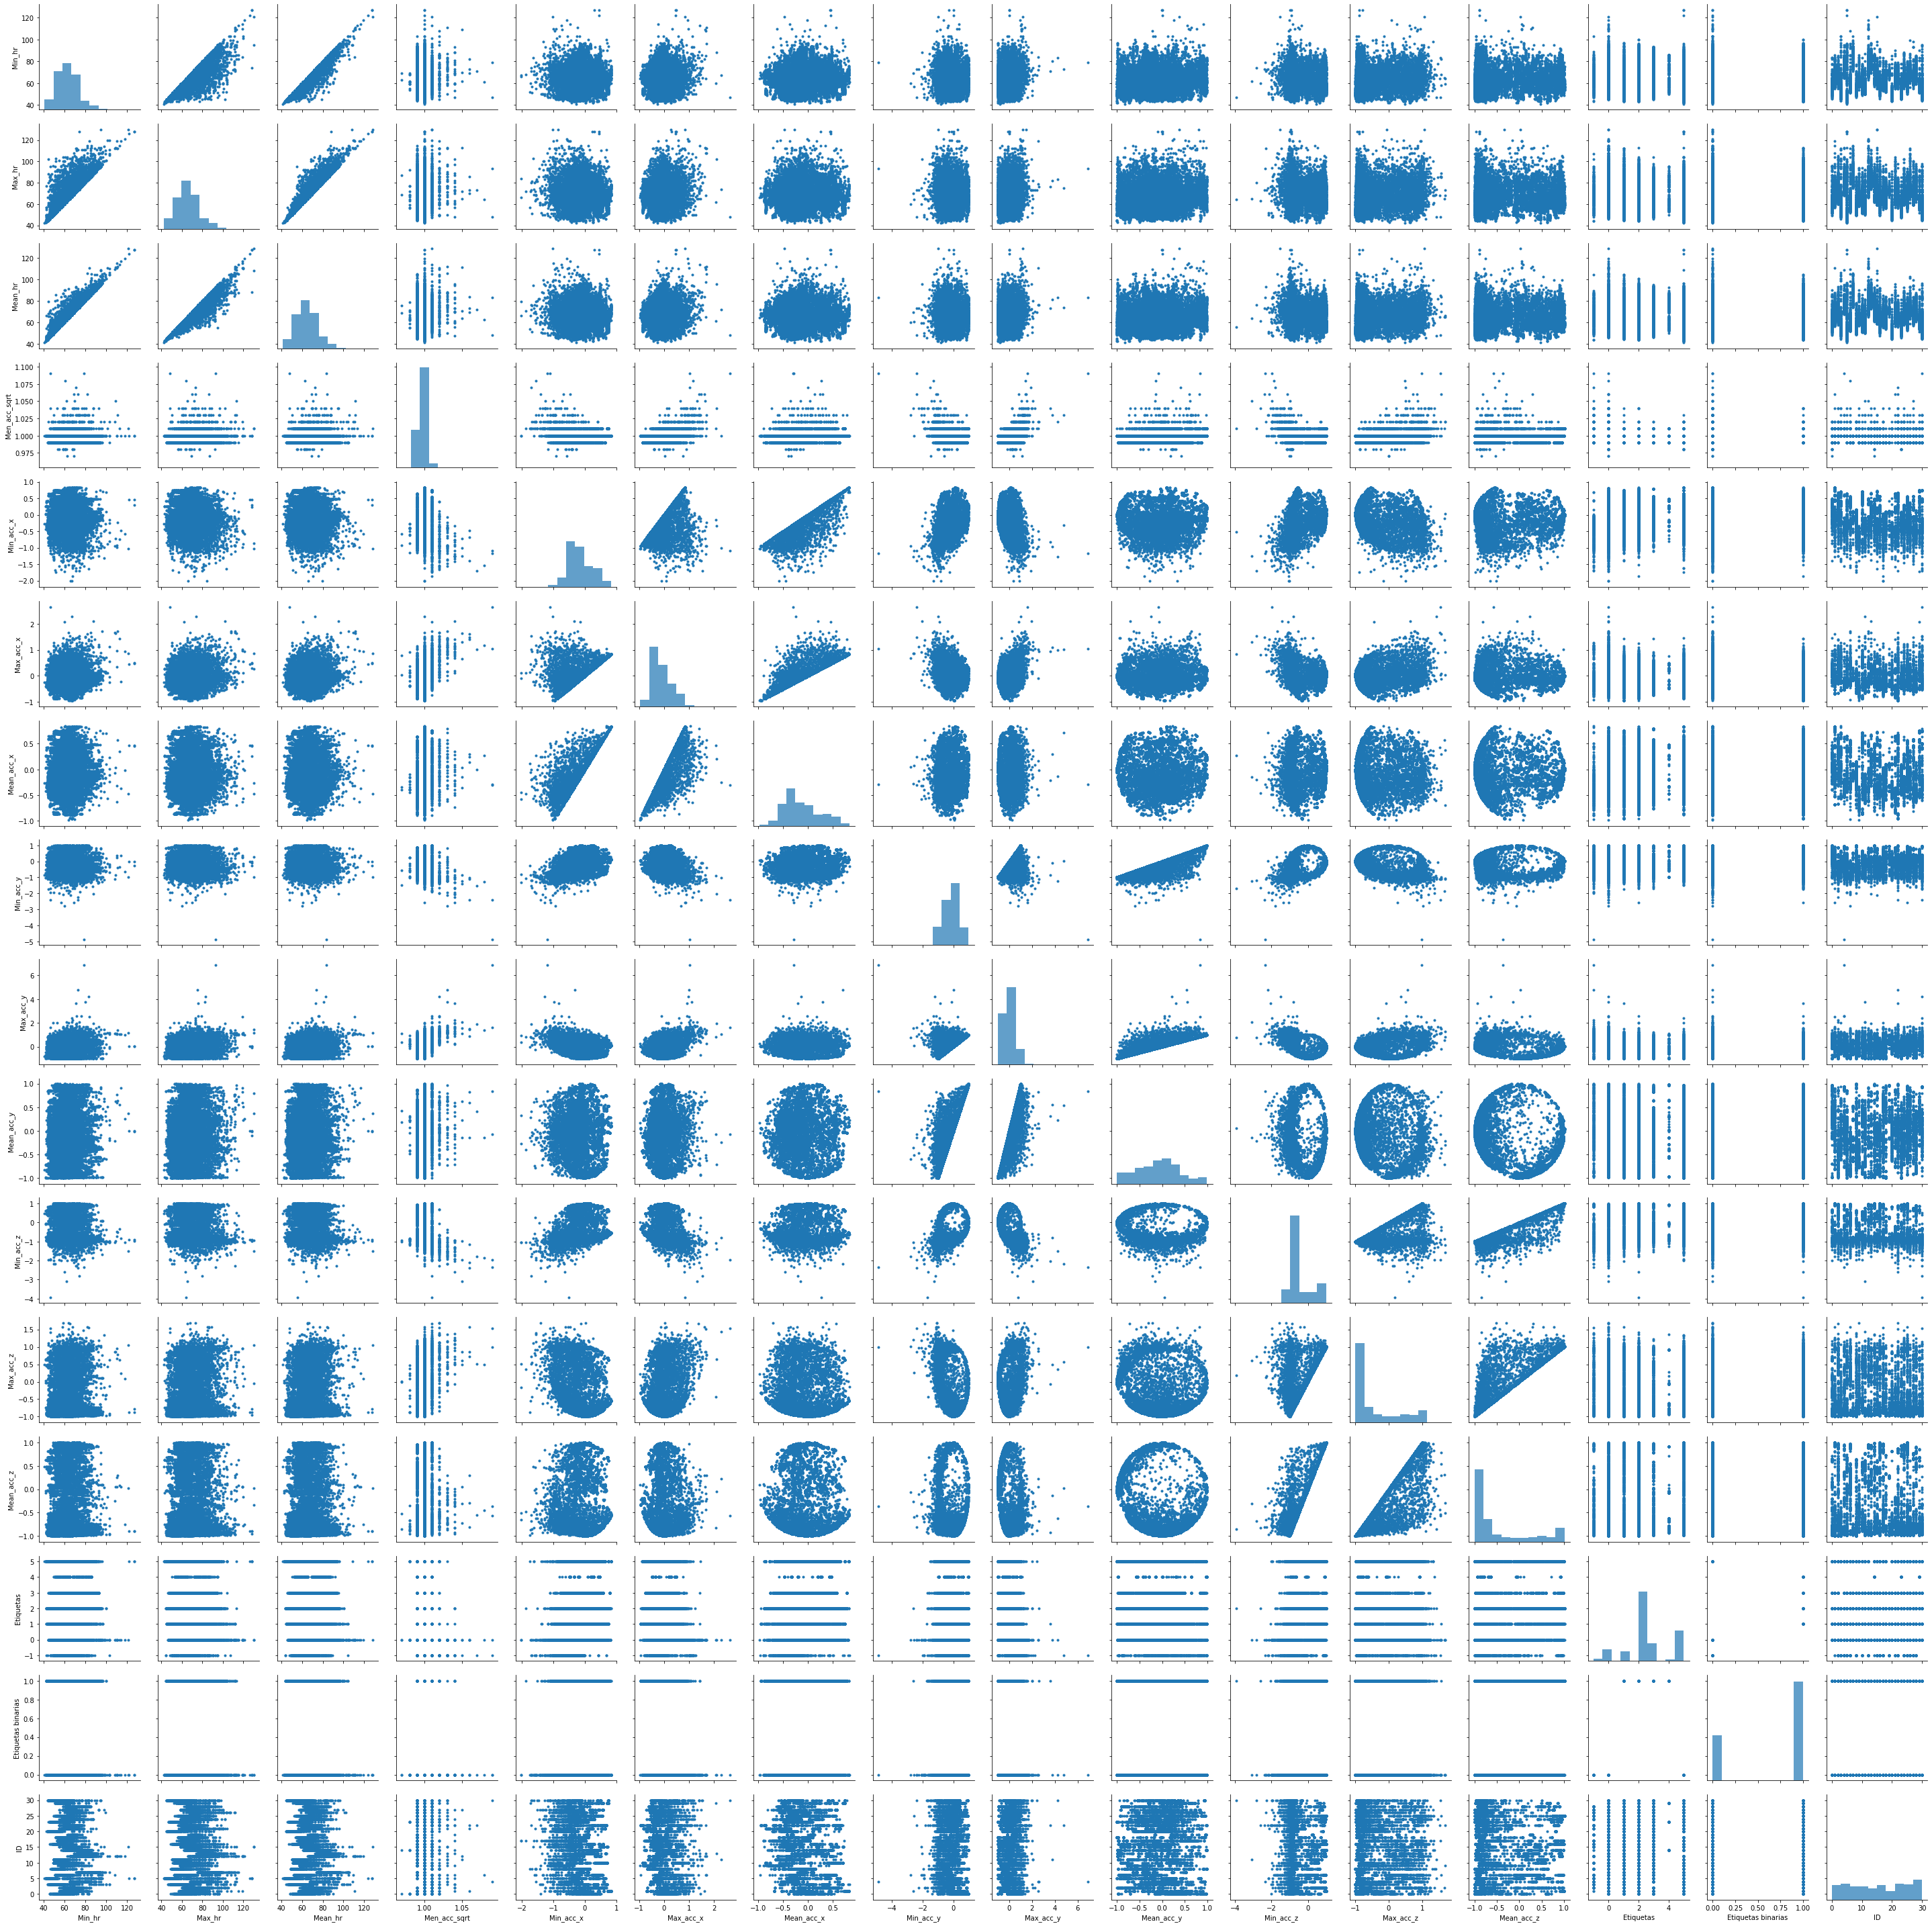

In [12]:
disper = sns.PairGrid(clean_df)
disper = disper.map_diag(plt.hist, alpha=0.7)
disper = disper.map_offdiag(plt.scatter, marker='.')

**MAPA DE CALOR**

Diagrama que nos devuelve la relación lineal entre las variables.

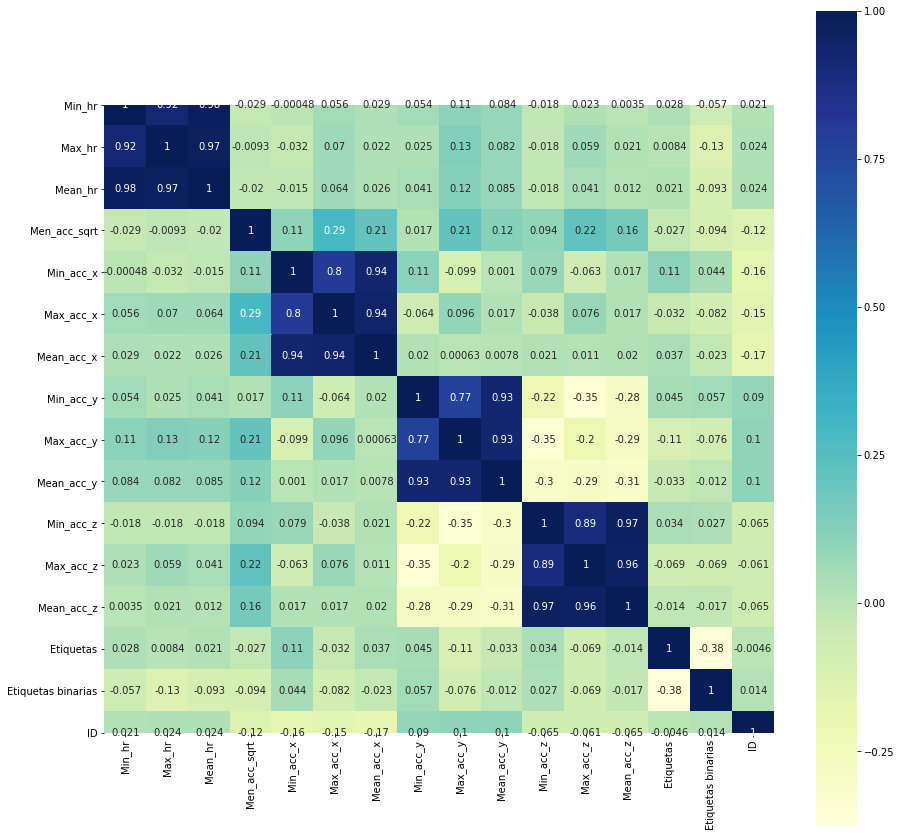

In [13]:
f, ax = plt.subplots(figsize=(15,15))
corr = clean_df.corr()
#sns.heatmap(corr)
sns.heatmap(corr, annot=True, cmap="YlGnBu", xticklabels=corr.columns.values, yticklabels=corr.columns.values,square=True)